1 - 80/20 validation split

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

file = '1_validimg.hdf5'
with h5py.File(file, 'r') as rd:
    x_train = np.array(rd['x_train'])
    y_train = np.array(rd['y_train'])
    x_test = np.array(rd['x_test'])
    y_test = np.array(rd['y_test'])

XT = np.copy(x_train)
XT = XT.astype('float32')/255

XTE = np.copy(x_test)
XTE = XTE.astype('float32')/255

class_enum = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
print(XT.shape)
print(y_train.shape)
print(XTE.shape)
print(y_test.shape)

(69600, 3, 125, 125)
(69600,)
(17400, 3, 125, 125)
(17400,)


In [28]:
class ASLSet(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        'Initialization'
        self.labels = labels
        self.images = images
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = torch.from_numpy(img)
        Y = lab
        
        return X, Y

train_set = ASLSet(XT,y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)

test_set = ASLSet(XTE, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100, shuffle = False)

loss_func = nn.CrossEntropyLoss()

Epoch: 01: Train Loss: 0.0337, Train Accuracy: 3.514%
            Test Loss: 0.0337, Test Accuracy: 3.770%
Epoch: 02: Train Loss: 0.0336, Train Accuracy: 4.657%
            Test Loss: 0.0332, Test Accuracy: 6.753%
Epoch: 03: Train Loss: 0.0256, Train Accuracy: 25.075%
            Test Loss: 0.0225, Test Accuracy: 38.770%
Epoch: 04: Train Loss: 0.0096, Train Accuracy: 68.243%
            Test Loss: 0.0055, Test Accuracy: 81.259%
Epoch: 05: Train Loss: 0.0042, Train Accuracy: 85.718%
            Test Loss: 0.0027, Test Accuracy: 90.540%
Epoch: 06: Train Loss: 0.0026, Train Accuracy: 91.365%
            Test Loss: 0.0021, Test Accuracy: 93.213%
Epoch: 07: Train Loss: 0.0014, Train Accuracy: 95.056%
            Test Loss: 0.0012, Test Accuracy: 96.063%
Epoch: 08: Train Loss: 0.0013, Train Accuracy: 96.045%
            Test Loss: 0.0010, Test Accuracy: 96.707%
Epoch: 09: Train Loss: 0.0034, Train Accuracy: 90.049%
            Test Loss: 0.0030, Test Accuracy: 90.747%
Epoch: 10: Train Loss: 

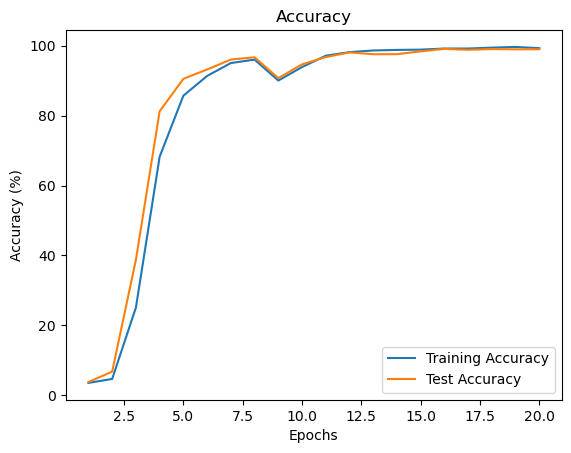

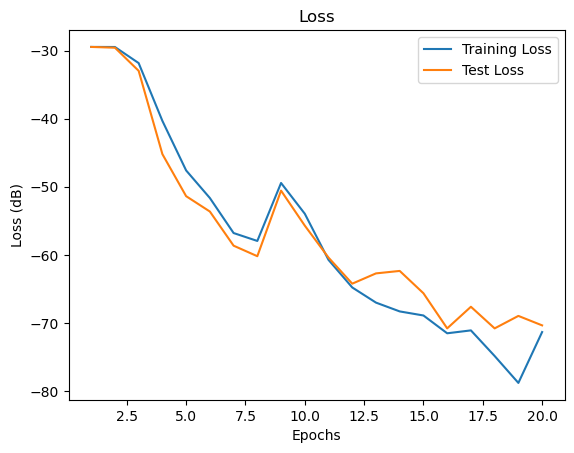

In [29]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()

        self.cnn_3_8 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_8_16= nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_16_24 = nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_24_24 = nn.Conv2d(in_channels = 24, out_channels = 24, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')

        self.drp = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.batch_8 = nn.BatchNorm2d(8)
        self.batch_16 = nn.BatchNorm2d(16)
        self.batch_24 = nn.BatchNorm2d(24)

        self.fc1 = nn.Linear(600, 200) # Will need to change based on CNN Option
        self.fc2 = nn.Linear(200, 100)
        self.output = nn.Linear(100, 29)
        
    def forward(self, x):
        
        ## CNN Option 1
        x = self.pool(F.relu(self.cnn_3_8(x)))
        x = self.pool(F.relu(self.cnn_8_16(x)))
        x = self.pool(F.relu(self.cnn_16_24(x)))
        x = self.pool(F.relu(self.cnn_24_24(x)))

        ## CNN Option 2
        # x = F.relu(self.cnn_3_8(x))
        # x = self.batch_8(self.pool(x))
        # x = F.relu(self.cnn_8_16(x))
        # x = self.batch_16(self.pool(x))
        # x = F.relu(self.cnn_16_24(x))
        # x = self.batch_24(self.pool(x))

        ## CNN Option 3
        # x = F.relu(self.cnn_3_8(x))
        # x = self.batch_8(self.pool(x))
        # x = F.relu(self.cnn_8_16(x))
        # x = self.batch_16(self.pool(x))
        # x = self.drop(x)
        # x = F.relu(self.cnn_16_24(x))
        # x = self.batch_24(self.pool(x))

        ## Dense Option 1
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        ## Dense Option 2
        # x = torch.flatten(x,1)
        # x = self.drp(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        return self.output(x)

model1 = Net1()
optimizer1 = torch.optim.SGD(model1.parameters(), lr = 0.06)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer1, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=10)

train_loss_arr = []
train_acc_arr = []
test_loss_arr = []
test_acc_arr = []
num_epochs = 20
for epoch in range(num_epochs):
    train_correct = 0
    test_correct = 0
    train_loss = 0
    test_loss = 0
    
    for images, labels in train_loader:
        # model1.train()
        # images = images.to(device)
        # labels = labels.to(device)

        #Forward Prop
        outputs = model1(images)
        predictions = torch.max(outputs,1)[1]
        loss = loss_func(outputs,labels)
        train_correct += (predictions == labels).sum().numpy()
        train_loss += loss.data
        
        #Back Prop
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

    for images, labels in test_loader:
        #Forward Prop
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        predictions = torch.max(outputs, 1)[1]
        test_correct += (predictions == labels).sum().numpy()
        test_loss += loss.data

    train_loss_arr.append(train_loss/len(train_loader.dataset))
    train_acc_arr.append(train_correct/len(train_loader.dataset))
    test_loss_arr.append(test_loss/len(test_loader.dataset))
    test_acc_arr.append(test_correct/len(test_loader.dataset))

    print(f'Epoch: {epoch+1:02d}: Train Loss: {(train_loss/len(train_loader.dataset)):.4f}, Train Accuracy: {(100*train_correct/len(train_loader.dataset)):2.3f}%')
    print("           ", f'Test Loss: {(test_loss/len(test_loader.dataset)):.4f}, Test Accuracy: {(100*test_correct/len(test_loader.dataset)):2.3f}%')
print(f'Final Train Accuracy: {100*train_acc_arr[-1]:2.3f}, Final Test Accuracy: {100*test_acc_arr[-1]:2.3f}')

a = plt.figure(1)
plt.plot(range(1,num_epochs+1), 100*np.array(train_acc_arr), label = "Training Accuracy")
plt.plot(range(1,num_epochs+1), 100*np.array(test_acc_arr), label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()
plt.show()

b = plt.figure(2)
plt.plot(range(1,num_epochs+1), 20*np.log10(np.array(train_loss_arr)), label = "Training Loss")
plt.plot(range(1,num_epochs+1), 20*np.log10(np.array(test_loss_arr)), label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (dB)")
plt.title("Loss")
plt.legend()
plt.show()

Testing against provided set (one image per class)

In [31]:
import os
import cv2
i = 0
images = []
labels = []

dir = os.listdir('/home/nick/Documents/Datasets/ASL/asl_alphabet_test')
dir.sort()
for image in dir:
    img = cv2.imread('/home/nick/Documents/Datasets/ASL/asl_alphabet_test/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (125, 125), interpolation = cv2.INTER_AREA)
    images.append(img)
    labels.append(i)
    i+=1

#Acounting for lack of delete test case
labels[-1] +=1
labels[-2] +=1

for i in range(len(images)):
    images[i] = images[i].T

images = np.float32(images)/255
labels = np.array(labels)

prov_test_set = ASLSet(images, y_test)
prov_test_loader = torch.utils.data.DataLoader(prov_test_set, batch_size = 32, shuffle = False)

test_correct = 0
for images, labels in prov_test_loader:
        #Forward Prop
        outputs = model1(images)
        predictions = torch.max(outputs, 1)[1]
        test_correct = (predictions == labels).sum().numpy()

print(f'Final Provided Test Accuracy: {100*test_correct:3.2f}%')

Final Provided Test Accuracy: 100.00%
